**PROJECT: DỰ ĐOÁN NGUY CƠ MẮC CÁC VẤN ĐỀ LIÊN QUAN ĐẾN SỨC KHỎE TINH THẦN**

# **1. IMPORT MODULE**

In [ ]:
import sys
from pathlib import Path

project_root = Path.cwd().parent  
sys.path.append(str(project_root))

from preprocessing.preprocessor import DataPreprocessor
from preprocessing.visualizer import DataVisualizer
from modeling.pipeline_model import ModelTrainPipeline

# **2. TIỀN XỬ LÝ DỮ LIỆU**

## **2.1. LOAD DATA**

In [2]:
# Nạp dữ liệu
d = DataPreprocessor.load('mental_health_dataset.csv')

# In ra thông tin về dữ liệu
d.summary()


Kích thước dữ liệu: (10000, 14)

Mô tả dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     9992 non-null   object 
 1   gender                  9998 non-null   object 
 2   employment_status       9994 non-null   object 
 3   work_environment        9999 non-null   object 
 4   mental_health_history   9988 non-null   object 
 5   seeks_treatment         9990 non-null   object 
 6   stress_level            9997 non-null   float64
 7   sleep_hours             9992 non-null   float64
 8   physical_activity_days  9990 non-null   float64
 9   depression_score        9998 non-null   float64
 10  anxiety_score           9993 non-null   float64
 11  social_support_score    9997 non-null   float64
 12  productivity_score      9995 non-null   float64
 13  mental_health_risk      9999 non-null   obj

---
**Nhận xét**: Ta thấy cột `age` có kiểu dữ liệu chuỗi nên ta chuyển sang kiểu dữ liệu số.

---

In [3]:
# Chuyển cột age sang kiểu số
d.convert(col="age")

In [4]:
# Tạo đặc trưng mới
d.create_new_feature()

10000 rows, 15 cols

In [5]:
# Phân loại các cột
cat_cols, num_cols = d.feature_separation()

Các cột phân loại: ['gender', 'employment_status', 'work_environment', 'mental_health_history', 'seeks_treatment', 'mental_health_risk']
Các cột số: ['age', 'stress_level', 'sleep_hours', 'physical_activity_days', 'depression_score', 'anxiety_score', 'social_support_score', 'productivity_score', 'productivity_base_on_stress']


## **2.2. TRỰC QUAN HÓA DỮ LIỆU BAN ĐẦU**

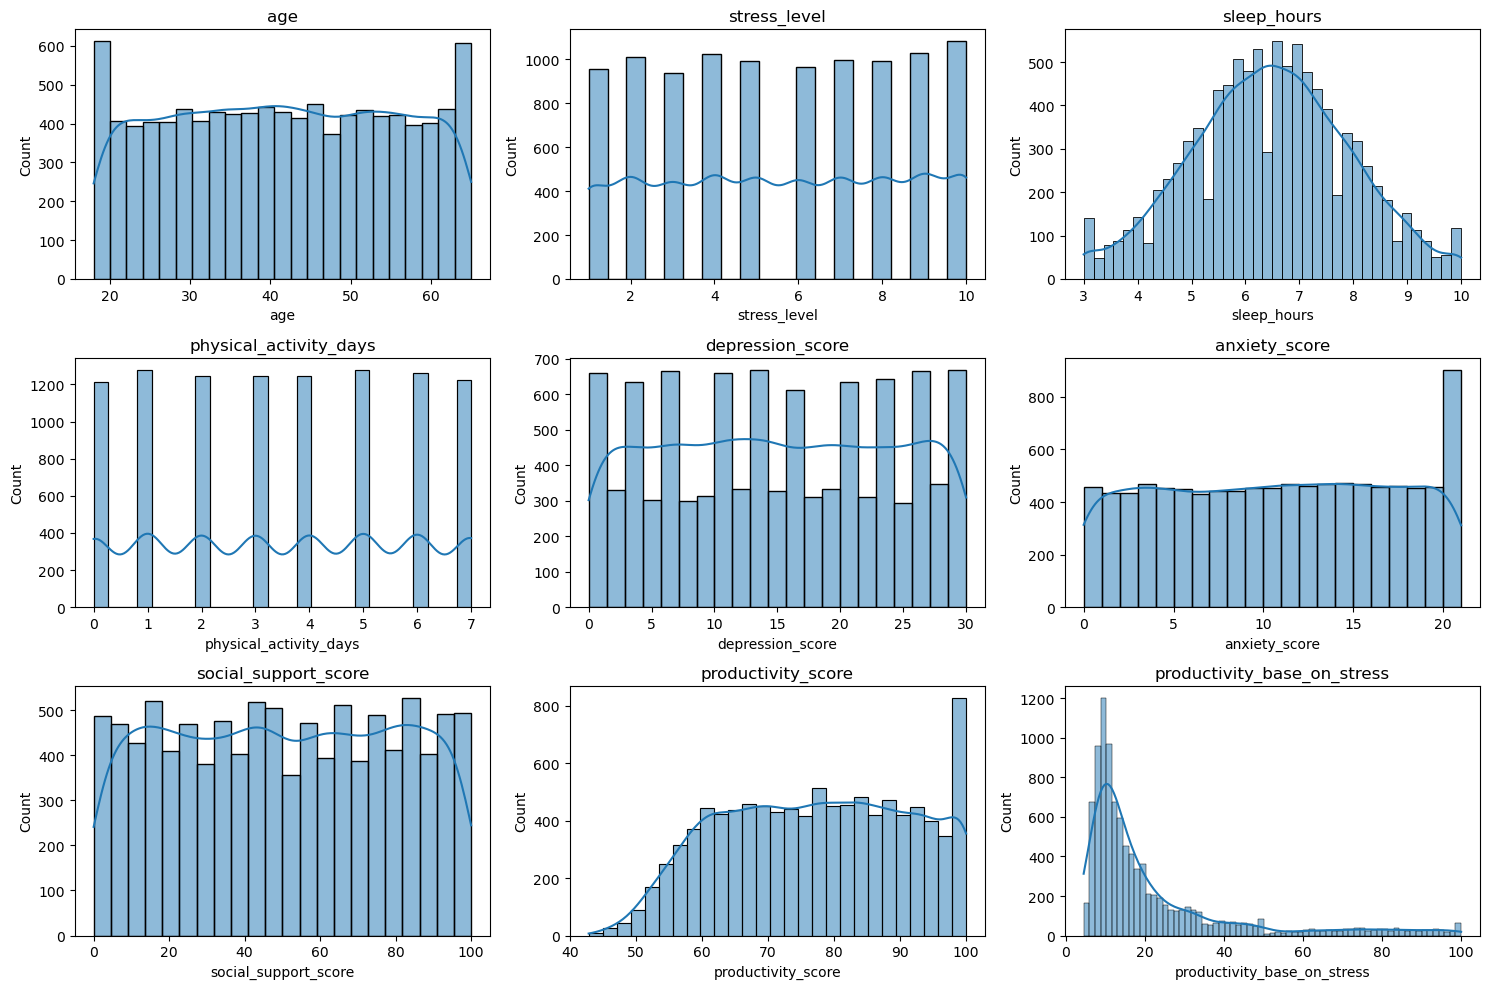

In [6]:
# Histogram cho các cột số
v = DataVisualizer(d.get_processed_data())
v.histogram()

---
**Nhận xét:**

- Các dữ liệu số có phân bố khá tốt, đa số các biến trải đều hoặc gần phân phối chuẩn. 
- `sleep_hours` có phân phối gần chuẩn. 
- `productivity_base_on_stress` lệch phải mạnh, cần xử lý trước khi train model. 
---

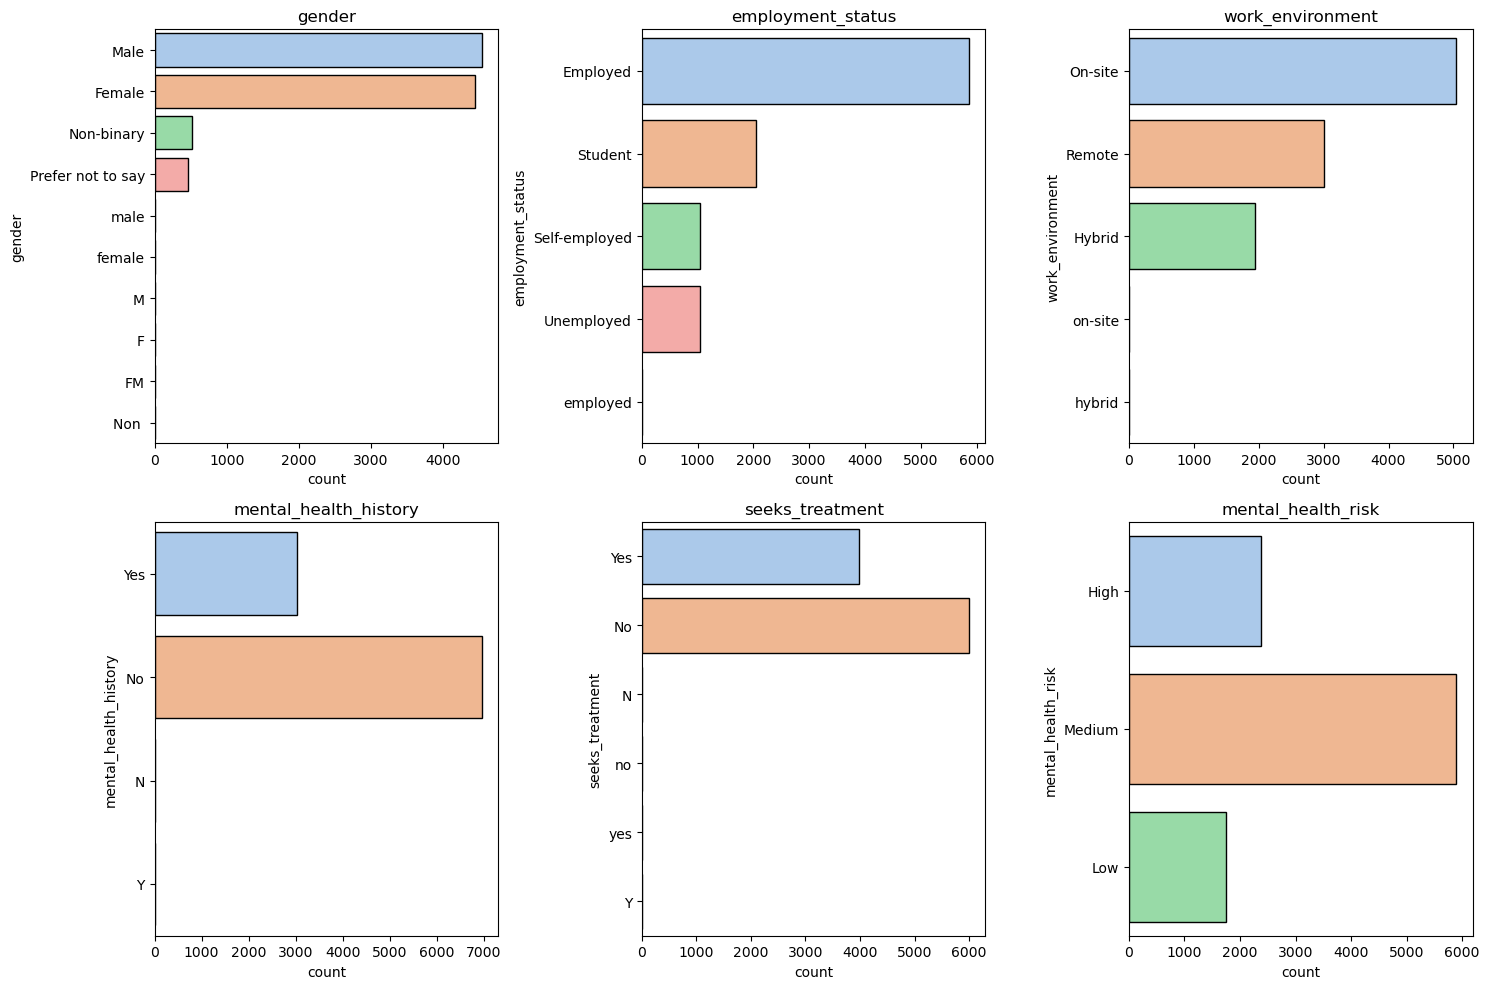

In [7]:
# Barplot cho các cột categorical
v.barplot()

---
**Nhận xét:**

- `gender`: Nam và nữ chiếm đa số, xuất hiện nhiều nhãn trùng/không chuẩn (male, female, M, F, …).
- `employment_status`: Phần lớn là Employed, các nhóm còn lại ít hơn → hơi mất cân bằng.
- `work_environment`: Chủ yếu On-site, sau đó là Remote, Hybrid thấp hơn.
- `mental_health_history`: Đa số không có tiền sử, nhưng tỷ lệ Yes vẫn đáng kể.
- `seeks_treatment`: Phần lớn không tìm điều trị, cho thấy rào cản hoặc thiếu tiếp cận chăm sóc.
- `mental_health_risk`: Medium chiếm đa số, High không nhỏ.

→  Tất cả các cột đều bị trùng lặp dữ liệu nên cần phải chuẩn hóa.

---

## **2.3. HANDLE MISSING VALUE**

In [8]:
# Xử lý dữ liệu thiếu
d.handle_missing_numeric()
d.handle_missing_categorical()

10000 rows, 15 cols

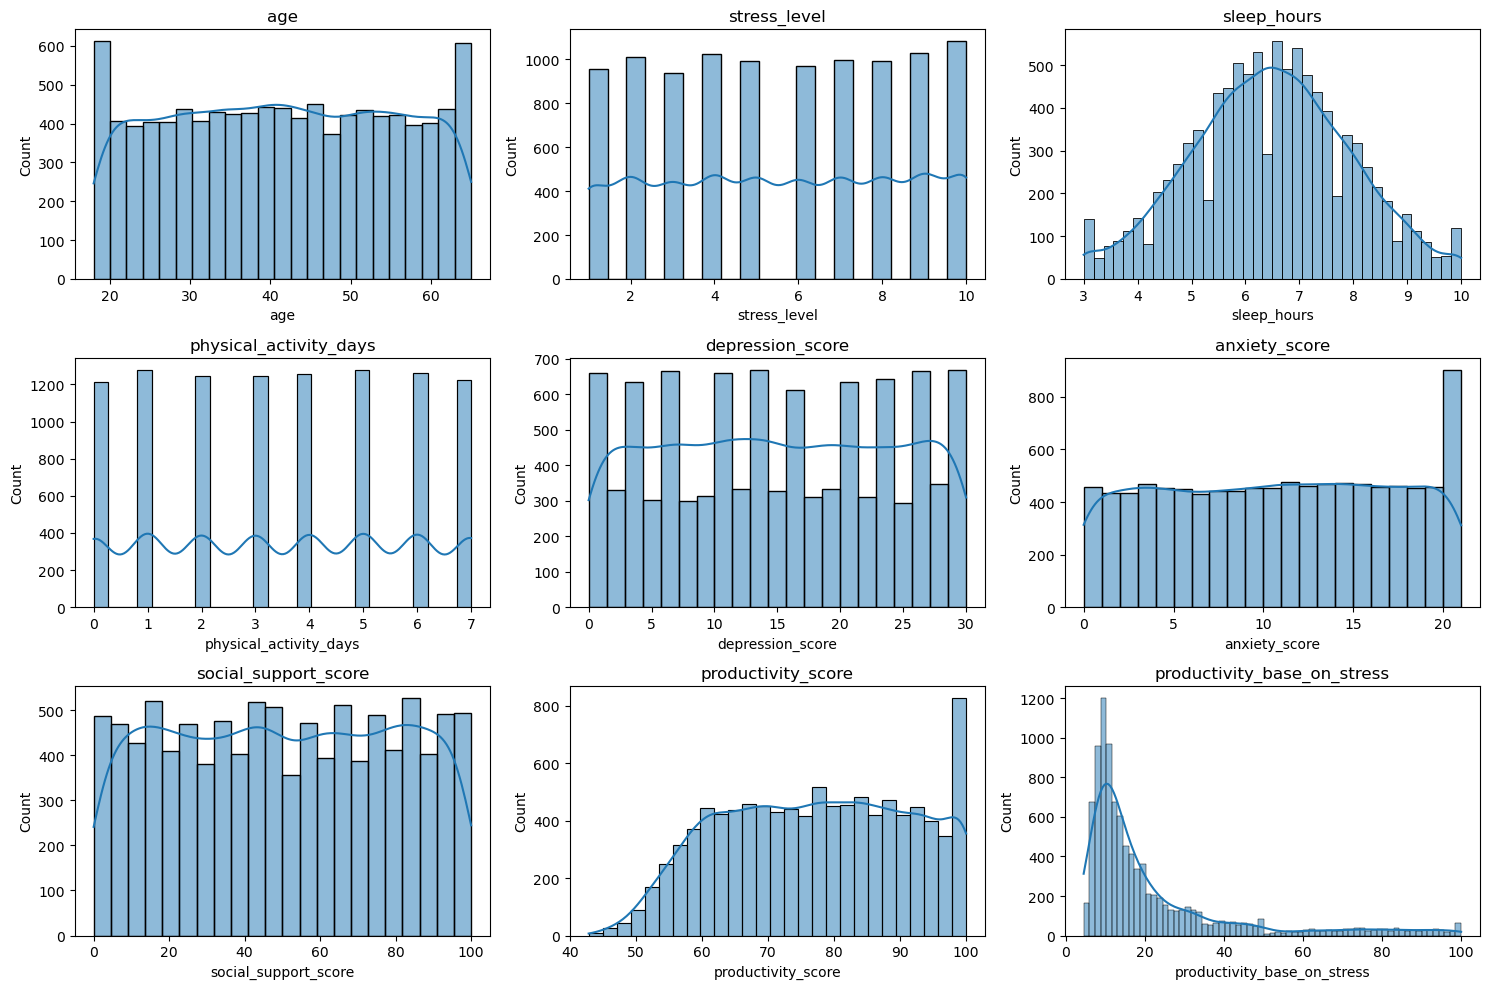

In [9]:
# Kiểm tra lại dữ liệu số sau khi xử lý giá trị thiếu
v = DataVisualizer(d.get_processed_data())
v.histogram()

## **2.4. NORMALIZE DATA**

In [10]:
# Chuẩn hóa đữ liệu trong các cột categorical
d.normalize_categorical()

********************
gender
Male                 4544
Female               4453
Non-binary            520
Prefer not to say     466
male                    9
M                       4
female                  1
F                       1
FM                      1
Non                     1
Name: count, dtype: int64
********************
employment_status
Employed         5871
Student          2042
Self-employed    1044
Unemployed       1042
employed            1
Name: count, dtype: int64
********************
work_environment
On-site    5043
Remote     3009
Hybrid     1946
on-site       1
hybrid        1
Name: count, dtype: int64
********************
mental_health_history
No     6970
Yes    3025
N         3
Y         2
Name: count, dtype: int64
********************
seeks_treatment
No     6009
Yes    3985
N         3
no        1
yes       1
Y         1
Name: count, dtype: int64
********************
mental_health_risk
Medium    5892
High      2369
Low       1739
Name: count, dtype: int64

***

10000 rows, 15 cols

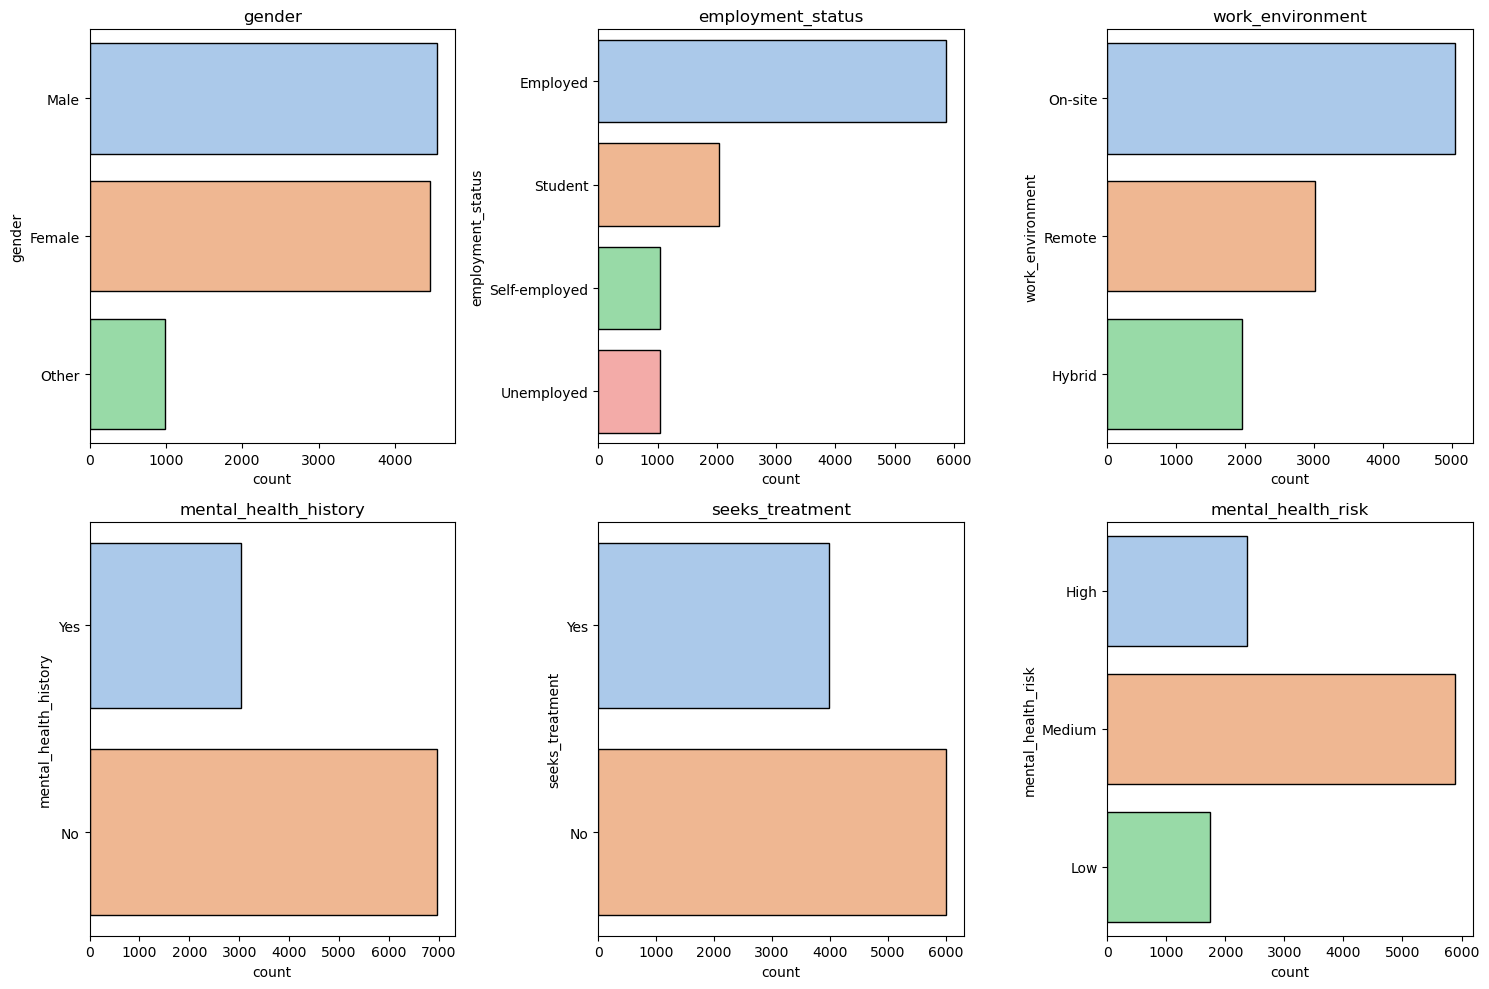

In [11]:
# Kiểm tra sau khi chuẩn hóa
v = DataVisualizer(d.get_processed_data())
v.barplot()

## **2.5. HANDLE OUTLIER**

In [12]:
# Kiểm tra giá trị skew cho các cột số
d.skewness_for_numeric_cols()

Skew cho các cột:
age                           -0.001251
stress_level                  -0.020437
sleep_hours                   -0.002150
physical_activity_days        -0.004078
depression_score               0.001475
anxiety_score                 -0.023253
social_support_score          -0.004649
productivity_score            -0.079479
productivity_base_on_stress    2.079007
dtype: float64


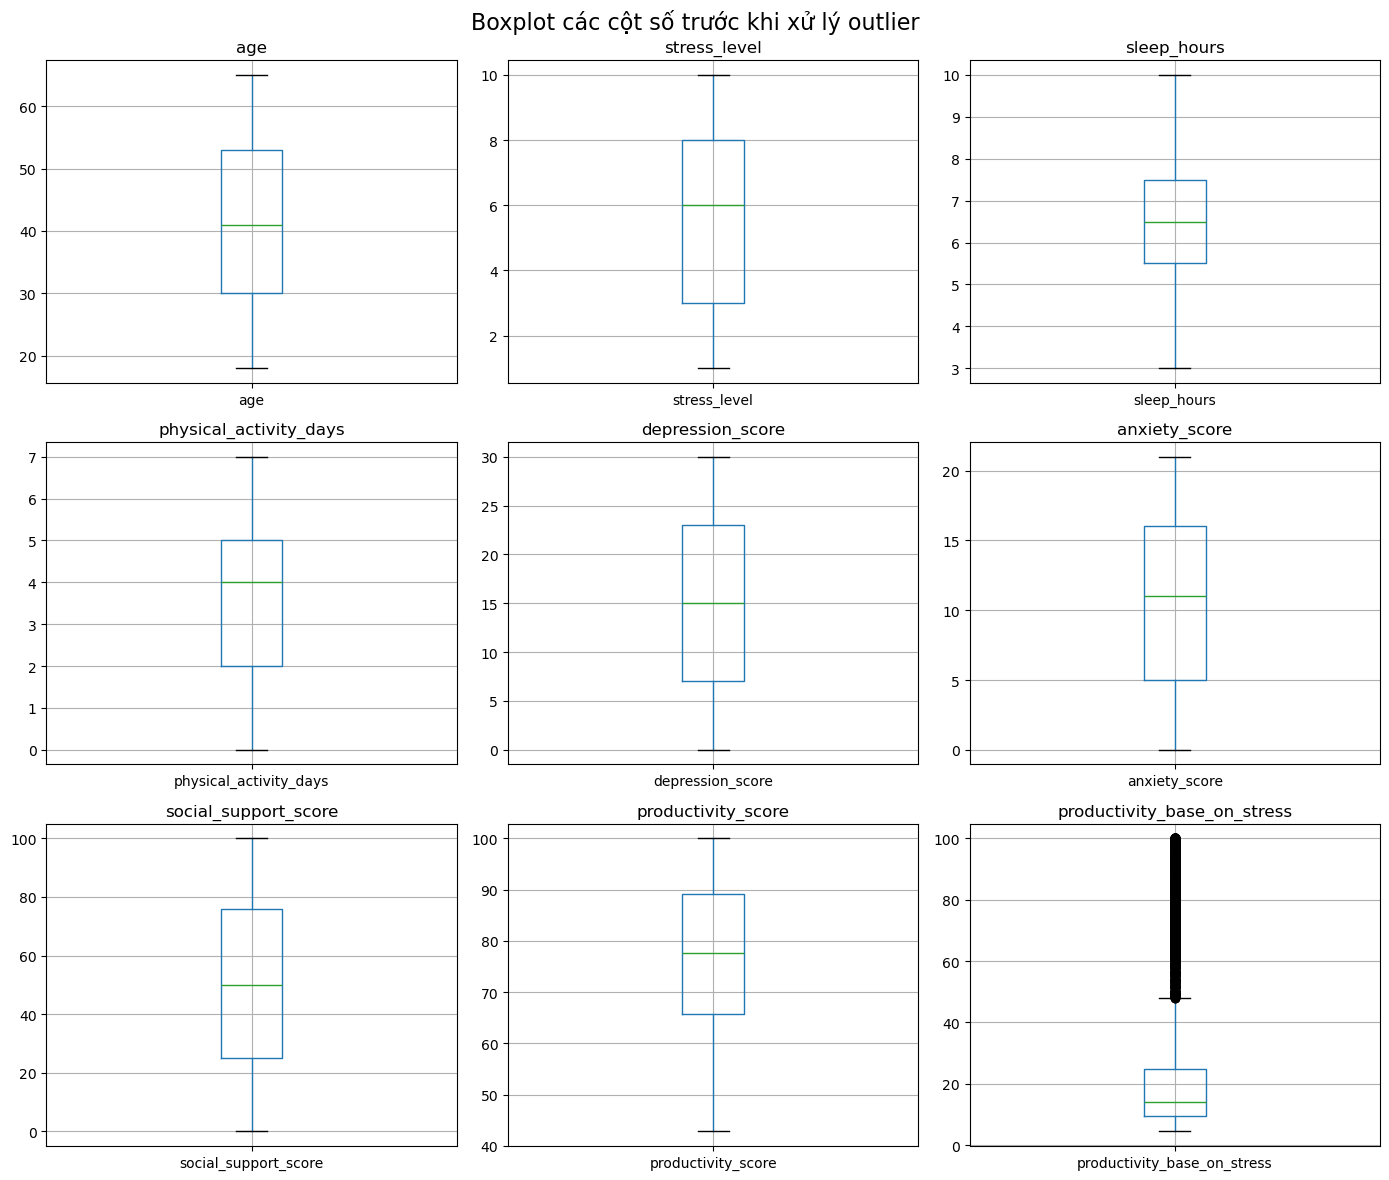

In [13]:
# Boxplot
v = DataVisualizer(d.get_processed_data())
v.boxplot_for_numeric_cols(title="Boxplot các cột số trước khi xử lý outlier")

---
**Nhận xét:**

- Dựa vào boxplot các cột số trước khi xử lý outliers, nhận thấy phần lớn các biến có phân phối khá ổn, không có outlier:

    - Điểm trầm cảm (`depression_score`) và điểm lo âu (`anxiety_score`) khá đối xứng, cho thấy hầu hết điểm đều nằm trong phạm vi vừa phải.
- Ngoại trừ `productivity_base_on_stress` có outlier rất lớn, cho thấy năng suất làm việc khi bị căng thẳng của phần lớn cá nhân là rất thấp, với 75% dữ liệu dưới 30.

---

In [14]:
# Xử lý outlier
d.handle_outlier()

10000 rows, 15 cols

In [15]:
# Boxplot sau khi xử lý
v = DataVisualizer(d.get_processed_data())
v.boxplot_for_numeric_cols(title="Boxplot các cột số sau khi xử lý outlier")

---
**Nhận xét:** 
- Sau khi được loại bỏ outlier, phân bố của `productivity_base_on_stress` ổn hơn nhưng vấn còn lệch phải lớn.

---

## **2.6. ENCODE, SCALE VÀ KIỂM TRA TƯƠNG QUAN**

In [16]:
# Encode
encoders = d.encode_categorical()

In [17]:
# Vẽ heatmap cho toàn bộ dữ liệu
v = DataVisualizer(d.get_processed_data())
v.heatmap()

---
**Nhận xét:** 
- Hầu hết các biến có tương quan rất thấp (≈ 0–0.03) → dữ liệu đa phần độc lập.
- Các tương quan mạnh:
    -  `depression_score` và `productivity_score`: tương quan âm rất mạnh (~ -0.94) → trầm cảm cao làm giảm năng suất.
    - `stress_level` và `productivity_base_on_stress`: âm mạnh (~ -0.88) → stress cao → năng suất giảm.

- `mental_health_risk`:
    - Tương quan âm vừa với `depression_score`, `anxiety_score` → nguy cơ mắc phải tăng khi điểm tâm lý xấu.
    - Tương quan dương nhẹ với `productivity_score`.

---

<Figure size 1500x500 with 0 Axes>

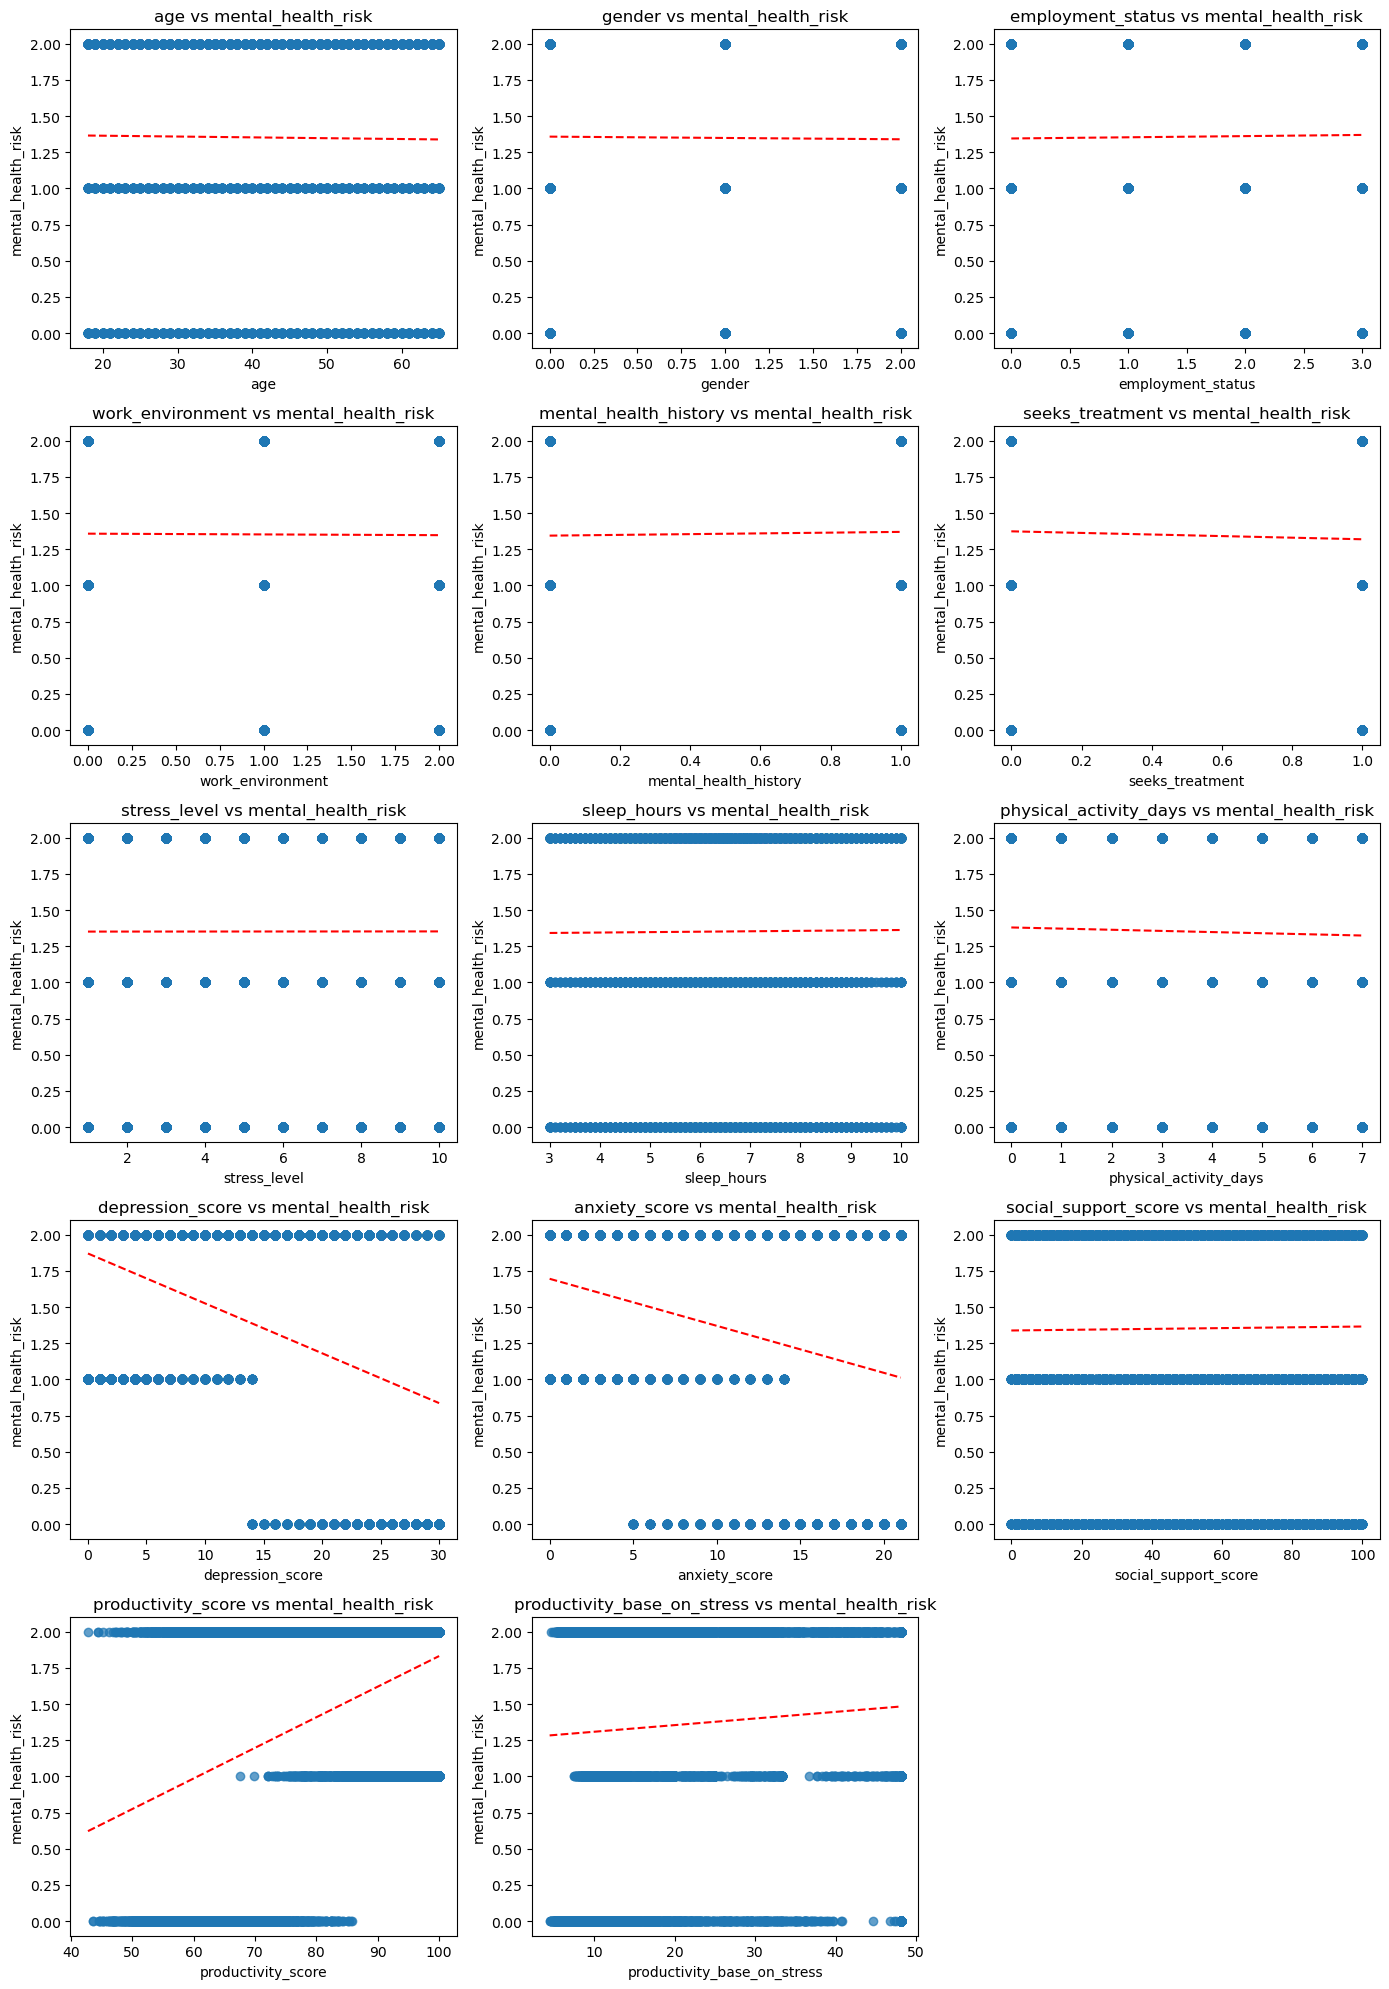

In [18]:
# Kiểm tra tương quan giữa các dữ liệu số với target
v.scatter(target="mental_health_risk")

---
**Nhận xét:** 

- Hầu hết các yếu tố (tuổi, giới tính, stress, giấc ngủ,...) không cho thấy mối quan hệ tuyến tính rõ ràng với `mental_health_risk`.
- `depression_score` và `anxiety_score` có quan hệ tuyến tính nghịch với `target` (nguy cơ mắc phải giảm khi điểm số tăng).
- `productivity_score` có quan hệ tuyến tính thuận với `target` (nguy cơ mắc phải tăng khi điểm năng suất tăng).

---

In [19]:
# Tương quan với target
v.heatmap_one_column(target="mental_health_risk")

---
**Nhận xét:** 
- Hầu hết các feature có tương quan rất thấp với `target` (≈ 0–0.03).
- `productivity_score` có tương quan dương nhẹ với `target` (≈ 0.35). 
- `depression_score` và `anxiety_score` có tương quan âm nhẹ với `target` (≈ –0.3).
---

In [20]:
# Scale dữ liệu
scaler = d.scale_features()

## **2.7. XUẤT DỮ LIỆU ĐÃ TIỀN XỬ LÝ**

In [21]:
d.new_data(output_path_str="new_mental_health_dataset.csv")

# **3. MODEL**

In [22]:
# Khởi tạo pipeline cho việc train model (bao gồm load data và split data)
pipe = (
    ModelTrainPipeline(random_seed=42, scaler=scaler, encoders=encoders, num_cols=num_cols)
    .load_data(data="new_mental_health_dataset.csv", target="mental_health_risk")
    .split_data()
)

## **3.1. LOGISTIC REGRESSION**

In [23]:
# Huấn luyện
pipe.train(model_name="logistic")

# Đánh giá 
lr_metrics = pipe.evaluate(encoders=encoders)

---
**Nhận xét:**

- Ở lớp `Low`: mô hình dự đoán đúng hết 348 trường hợp.
- Ở lớp `High`: mô hình dự đoán đúng hết 474 trường hợp.
- Ở lớp `Medium`: dự đoán đúng 1177/1178 trường hợp, nhầm 1 mẫu sang lớp `High`.

Tổng thể, mô hình rất tốt trong việc phân loại mức độ của `mental_health_risk`.

---

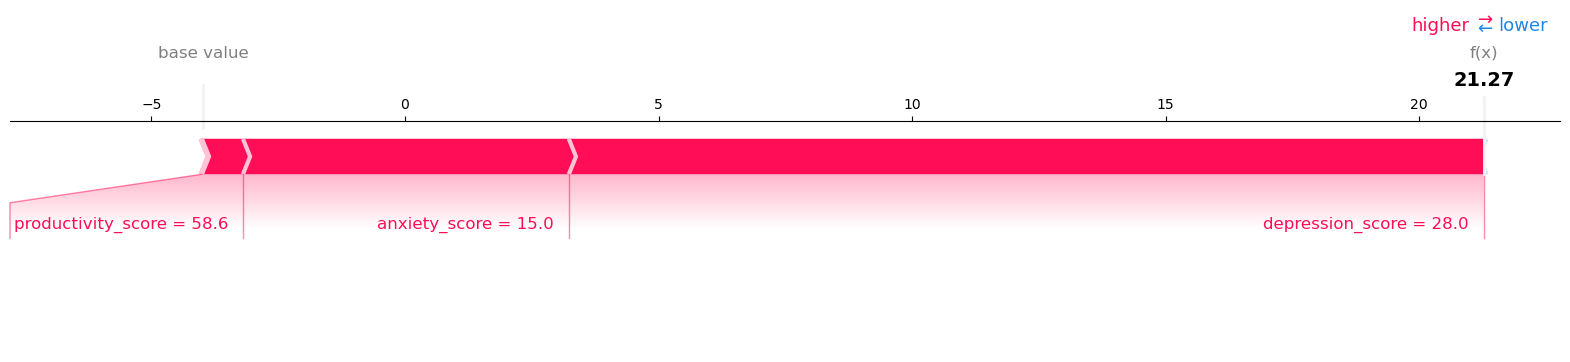

In [24]:
pipe.shap_force()

## **3.2. RANDOM FOREST**

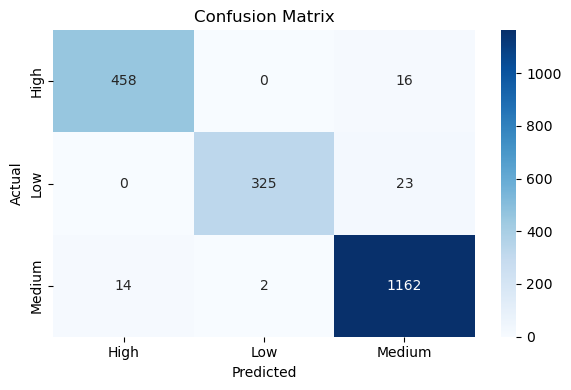

In [25]:
# Huấn luyện
pipe.train(model_name="randomforest")

# Đánh giá 
rf_metrics = pipe.evaluate(encoders=encoders)

---
**Nhận xét:**

- Ở lớp `High`: mô hình dự đoán đúng 458/474 trường hợp, có 16 mẫu nhầm sang lớp `Medium` (chiếm khoảng 3.16%).
- Ở lớp `Low`: mô hình dự đoán đúng 325/348 trường hợp, có 23 mẫu nhầm sang lớp `Medium`, (chiếm khoảng 6.61%).
- Ở lớp `Medium`: dự đoán đúng 1162/1178 trường hợp, nhầm 14 mẫu sang lớp `High` và 2 mẫu sang lớp `Low` (16 mẫu bị bỏ sót, chiếm khoảng 1.36%).

Tổng thể, mô hình dự đoán sai chủ yếu từ lớp `Low`, `High` sang lớp `Medium`.

---

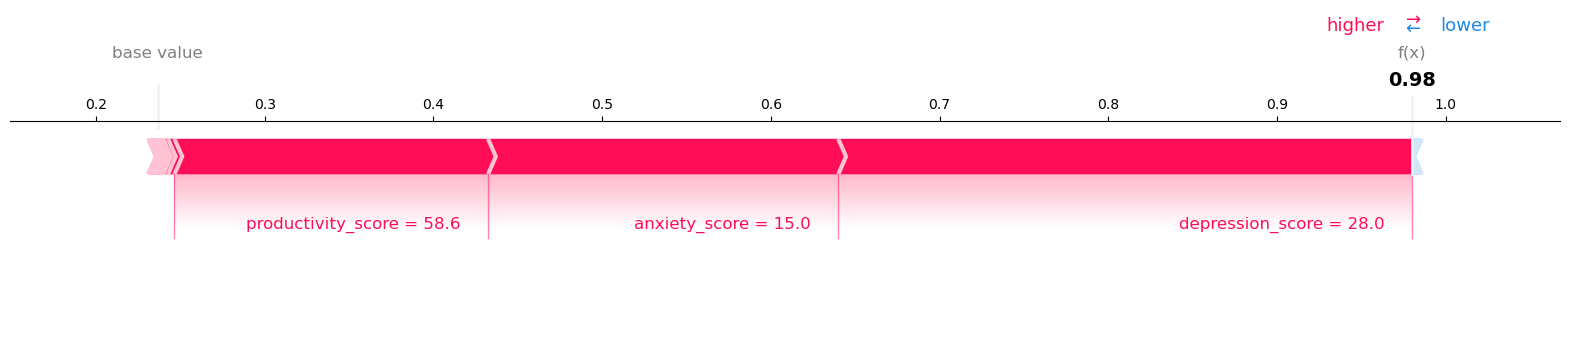

In [26]:
pipe.shap_force()

## **3.3. LightGBM**

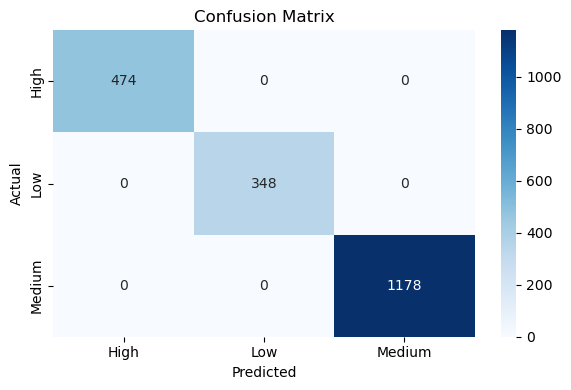

In [27]:
# Huấn luyện
pipe.train(model_name="lightgbm")

# Đánh giá 
lgb_metrics = pipe.evaluate(encoders=encoders)

---
**Nhận xét**: Mô hình dự đoán đúng hết tất cả trường hợp.

---

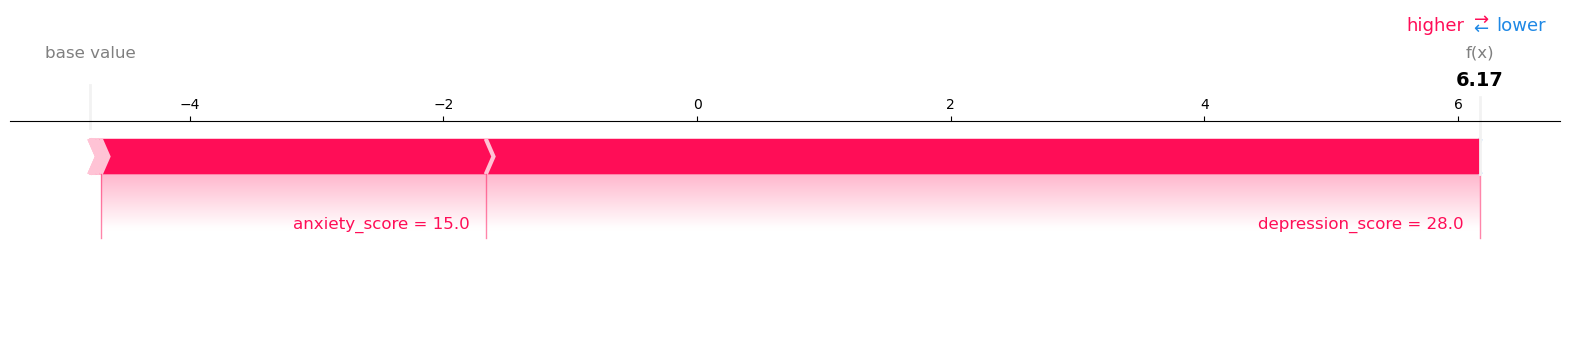

In [28]:
pipe.shap_force()

## **3.4. XGBOOST**

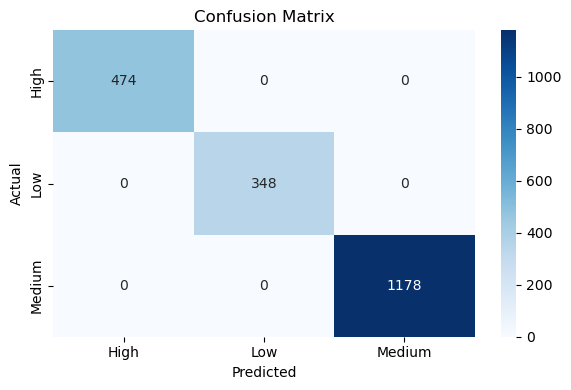

In [29]:
# Huấn luyện
pipe.train(model_name="xgboost")

# Đánh giá 
xgb_metrics = pipe.evaluate(encoders=encoders)

---
**Nhận xét**: Mô hình dự đoán đúng hết tất cả trường hợp.

---

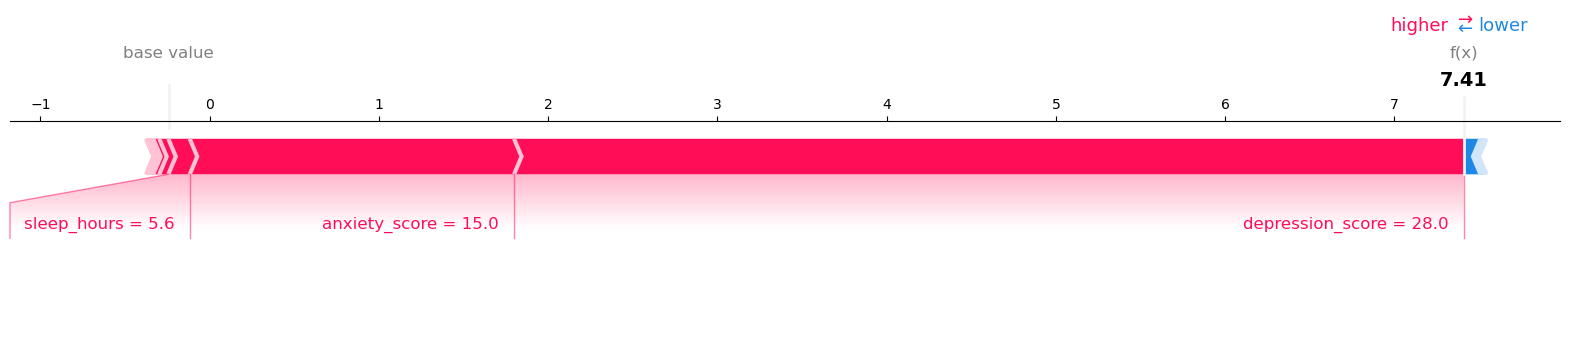

In [30]:
pipe.shap_force()

## **3.5. SO SÁNH CÁC MÔ HÌNH**

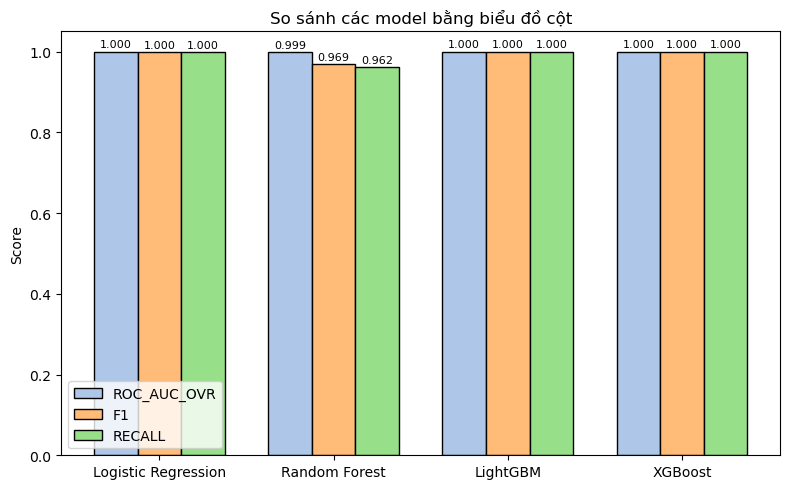

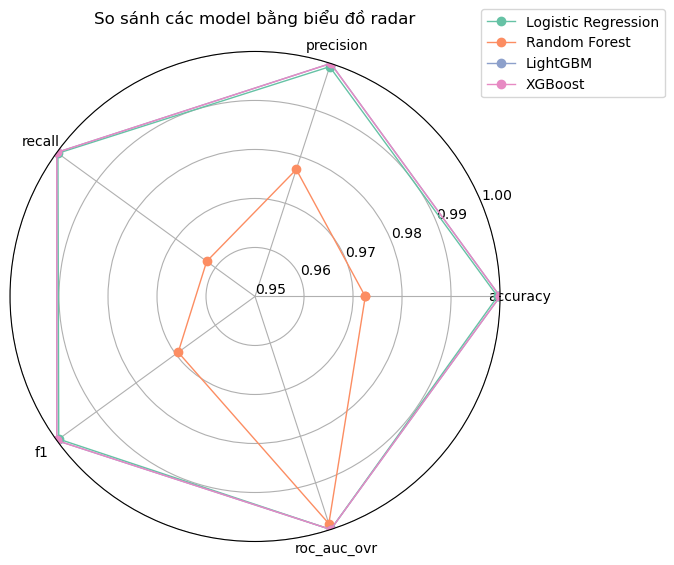

In [31]:
# Vẽ plot so sánh giữa các mô hình
model_metrics = {
    "Logistic Regression": lr_metrics,
    "Random Forest": rf_metrics,
    "LightGBM": lgb_metrics,
    "XGBoost": xgb_metrics
}
pipe.comparison_plot(model_metrics=model_metrics)

## **3.6. BEST MODEL**

### **3.6.1. BEST MODEL VỚI OPTUNA**

In [32]:
best_model = pipe.select_best_model()

Mô hình tốt nhất: xgboost


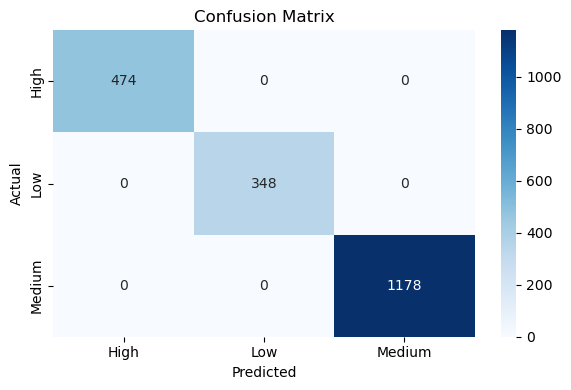

accuracy  precision  recall   f1  roc_auc_ovr
0       1.0        1.0     1.0  1.0          1.0

In [33]:
print("Mô hình tốt nhất:", best_model["best_model_name"])
pipe.evaluate(encoders=encoders)

In [34]:
print("Đánh giá cho tất cả các mô hình:")
best_model["all_metrics"]

Đánh giá cho tất cả các mô hình:


model_name  accuracy  precision    recall        f1  roc_auc_ovr
3      lightgbm    1.0000   1.000000  1.000000  1.000000     1.000000
2       xgboost    1.0000   1.000000  1.000000  1.000000     1.000000
0      logistic    0.9995   0.999298  0.999717  0.999507     0.999998
1  randomforest    0.9725   0.977250  0.962190  0.969377     0.998744

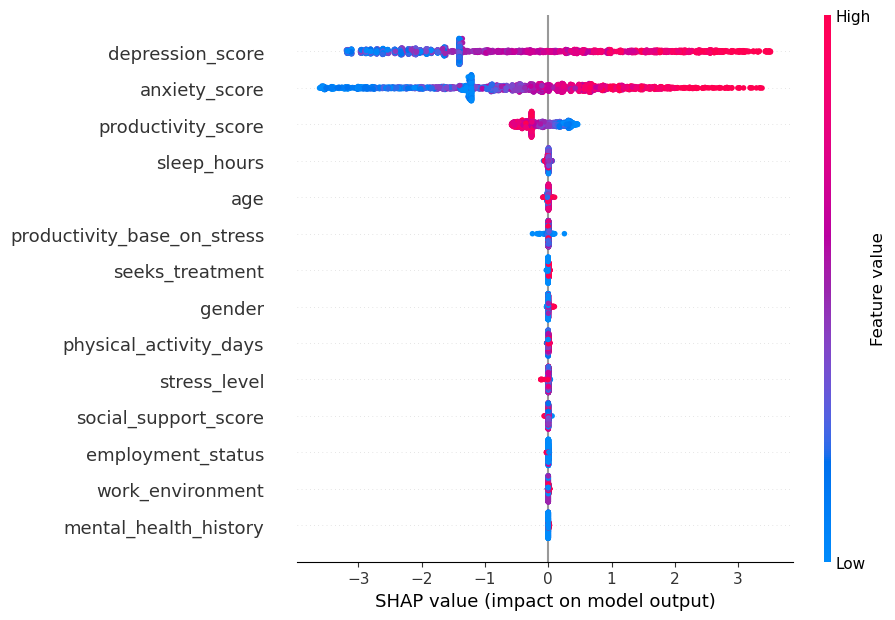

In [35]:
# Vẽ SHAP plot
pipe.shap_beeswarm()

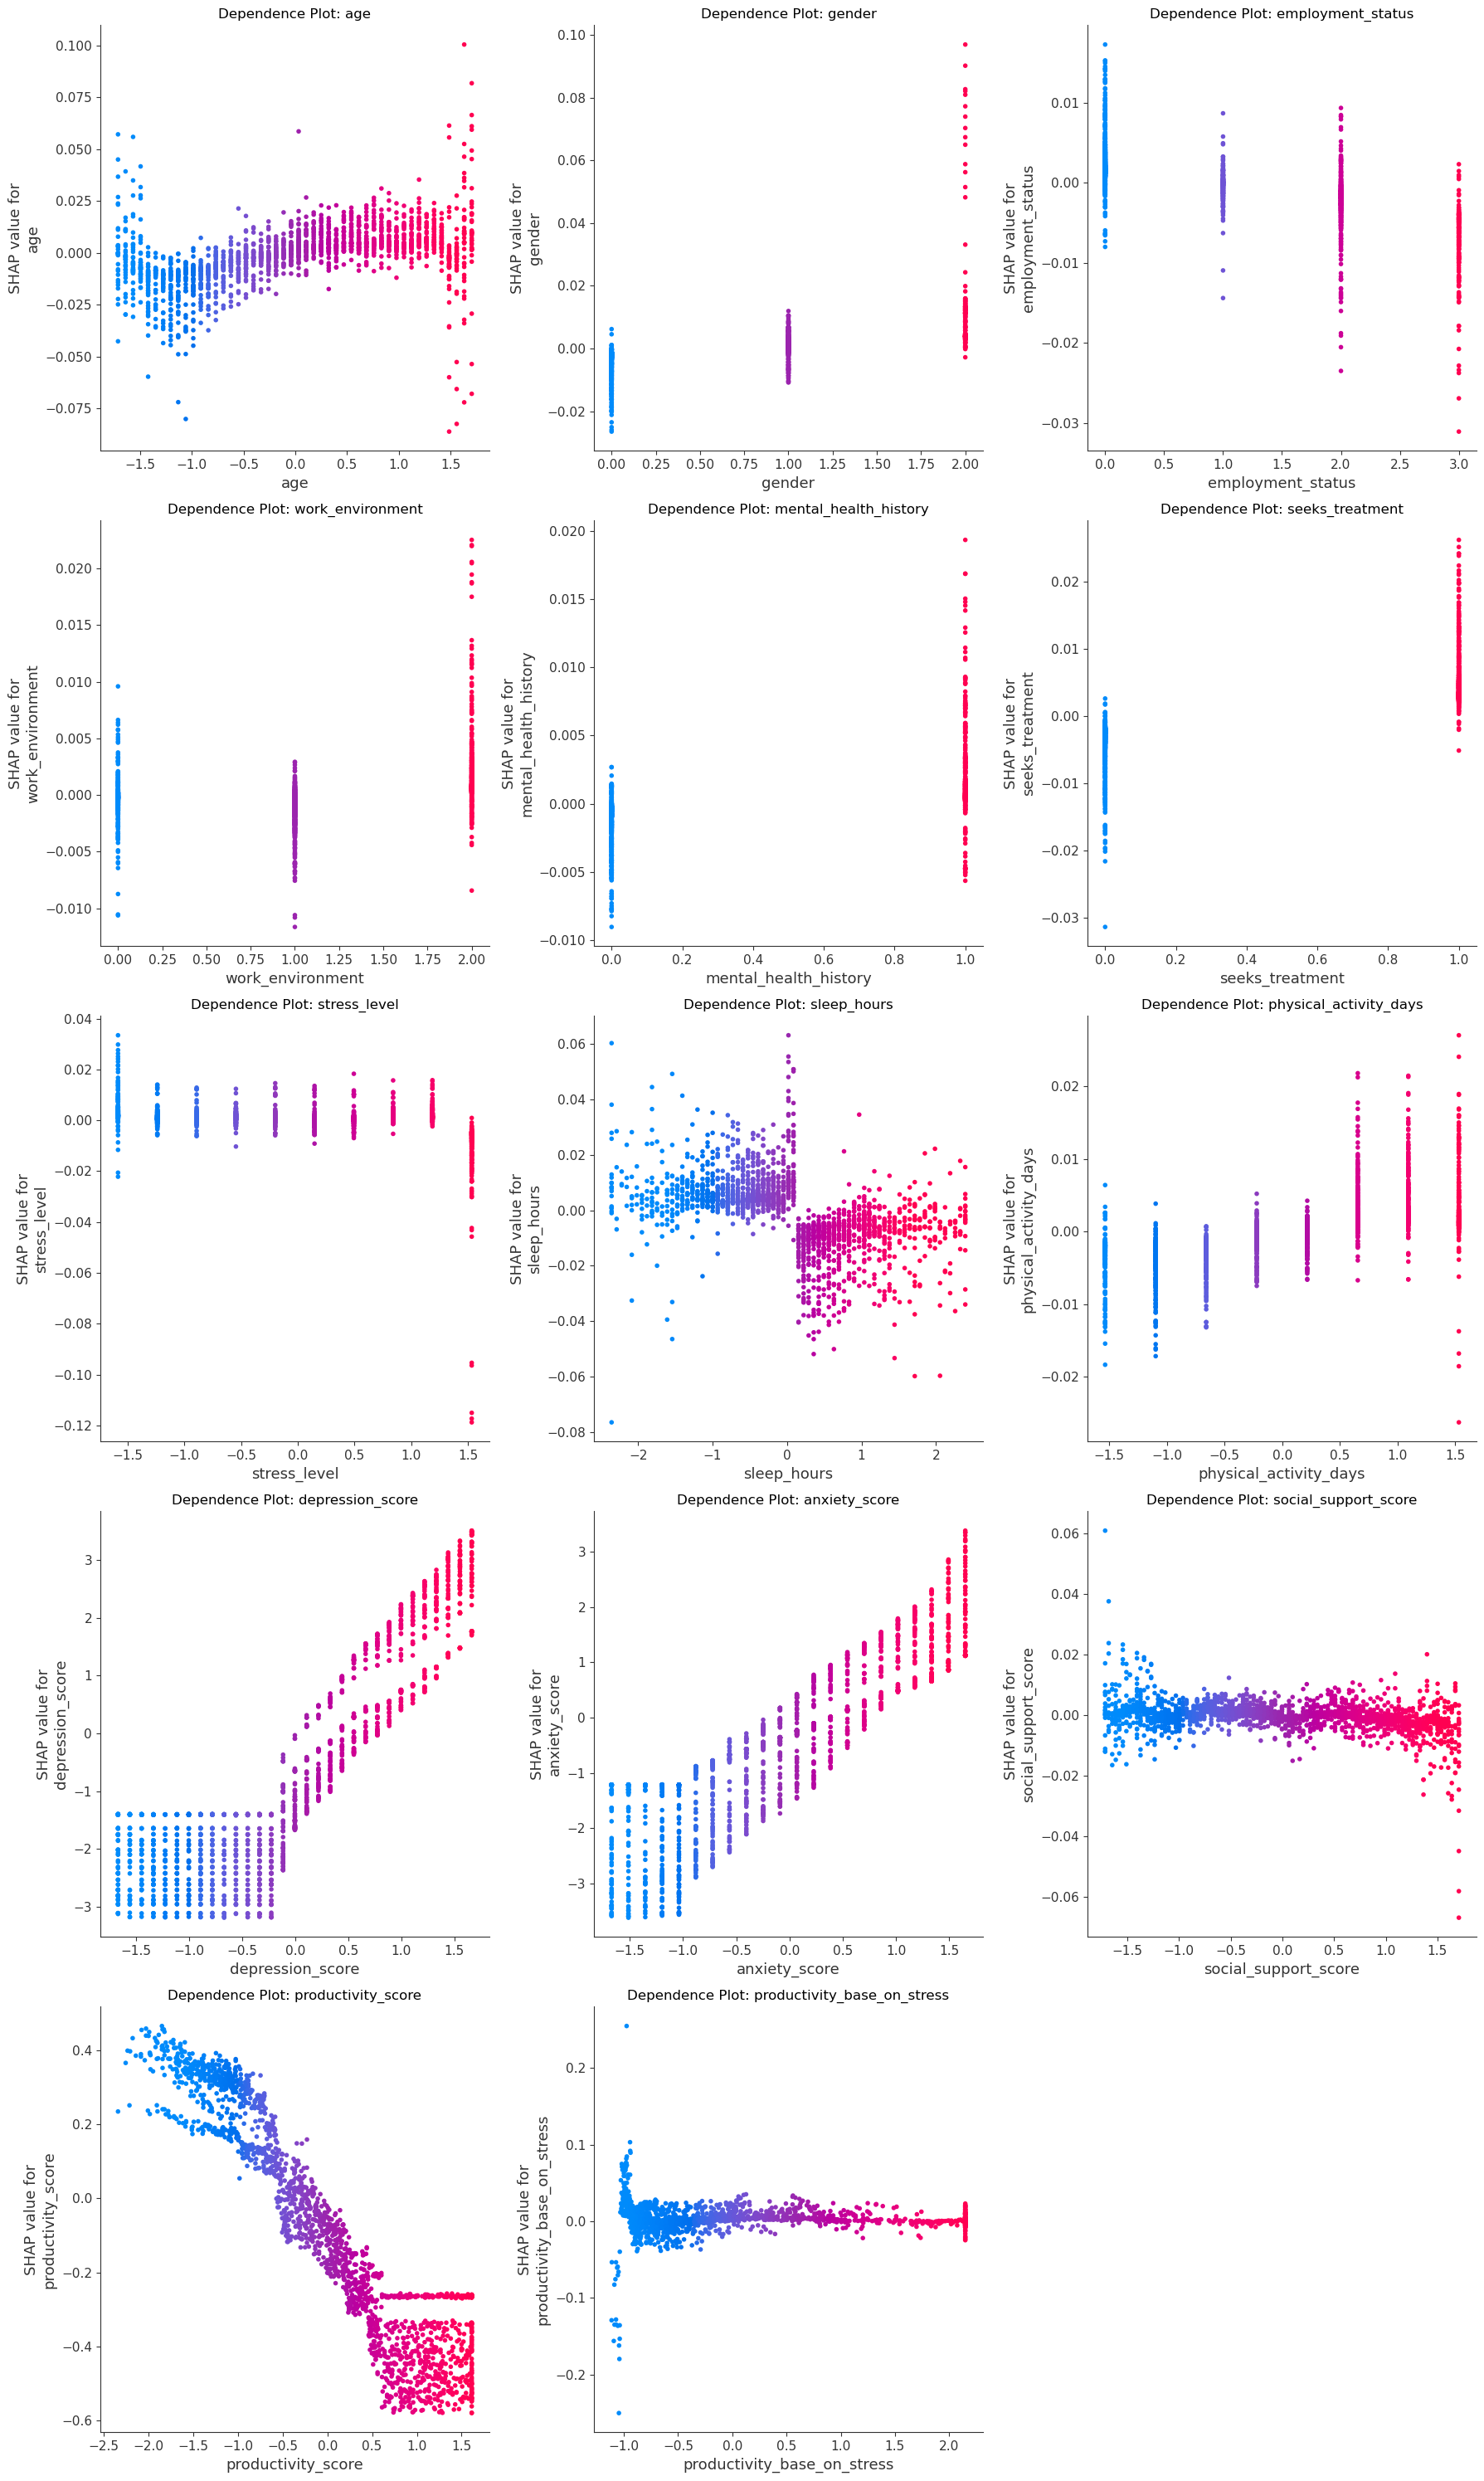

In [36]:
pipe.shap_dependence()

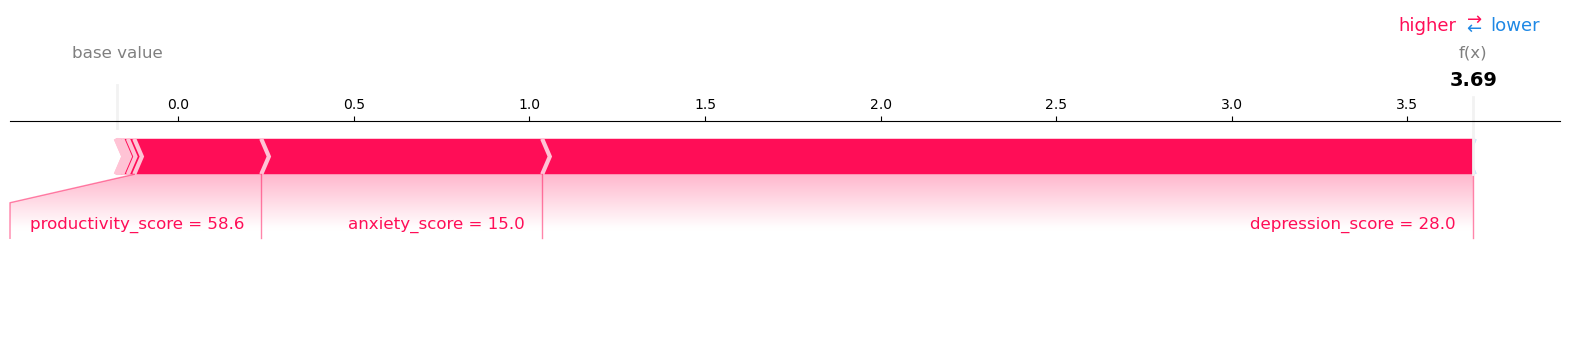

In [37]:
pipe.shap_force()

In [38]:
# Lưu model
pipe.save("Best_model_with_optuna.pkl")

---
**Nhận xét:**
Khi chọn mô hình tốt nhất, kết quả trả về cho thấy các điểm hiệu suất giữa lightgbm và xgboost là như nhau nên ta sẽ chạy thử mô hình với lightgbm tối ưu tham số.

---

In [ ]:
pipe.optimize_params(model_name="lightgbm")

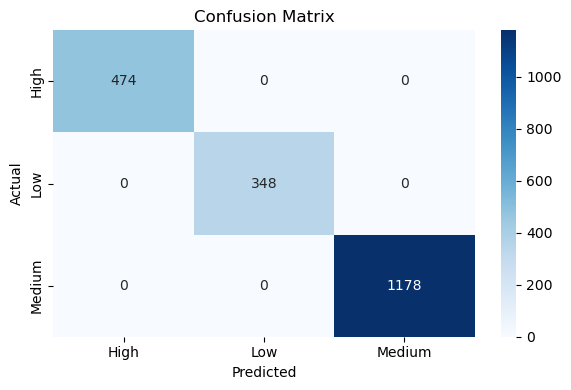

accuracy  precision  recall   f1  roc_auc_ovr
0       1.0        1.0     1.0  1.0          1.0

In [40]:
pipe.evaluate(encoders=encoders)

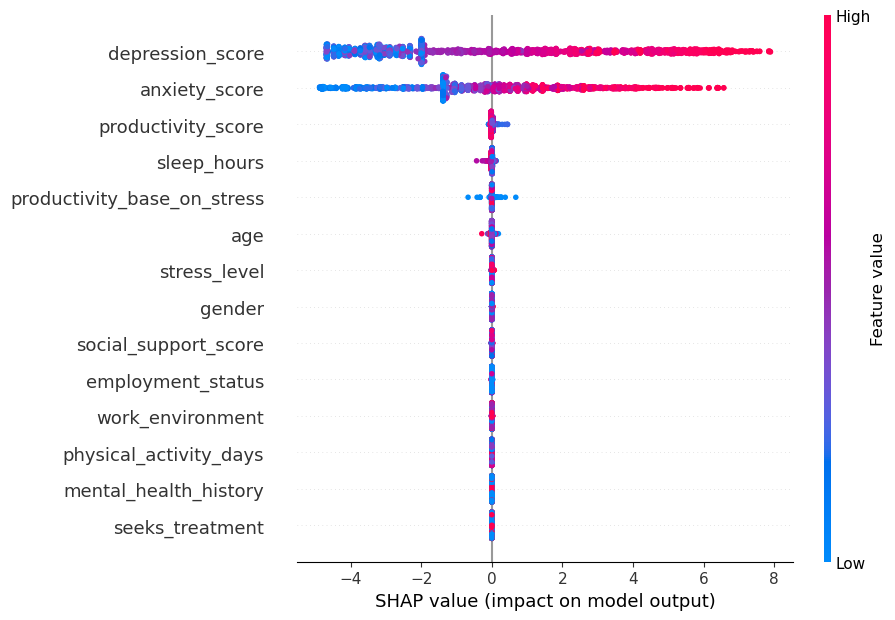

In [41]:
pipe.shap_beeswarm()

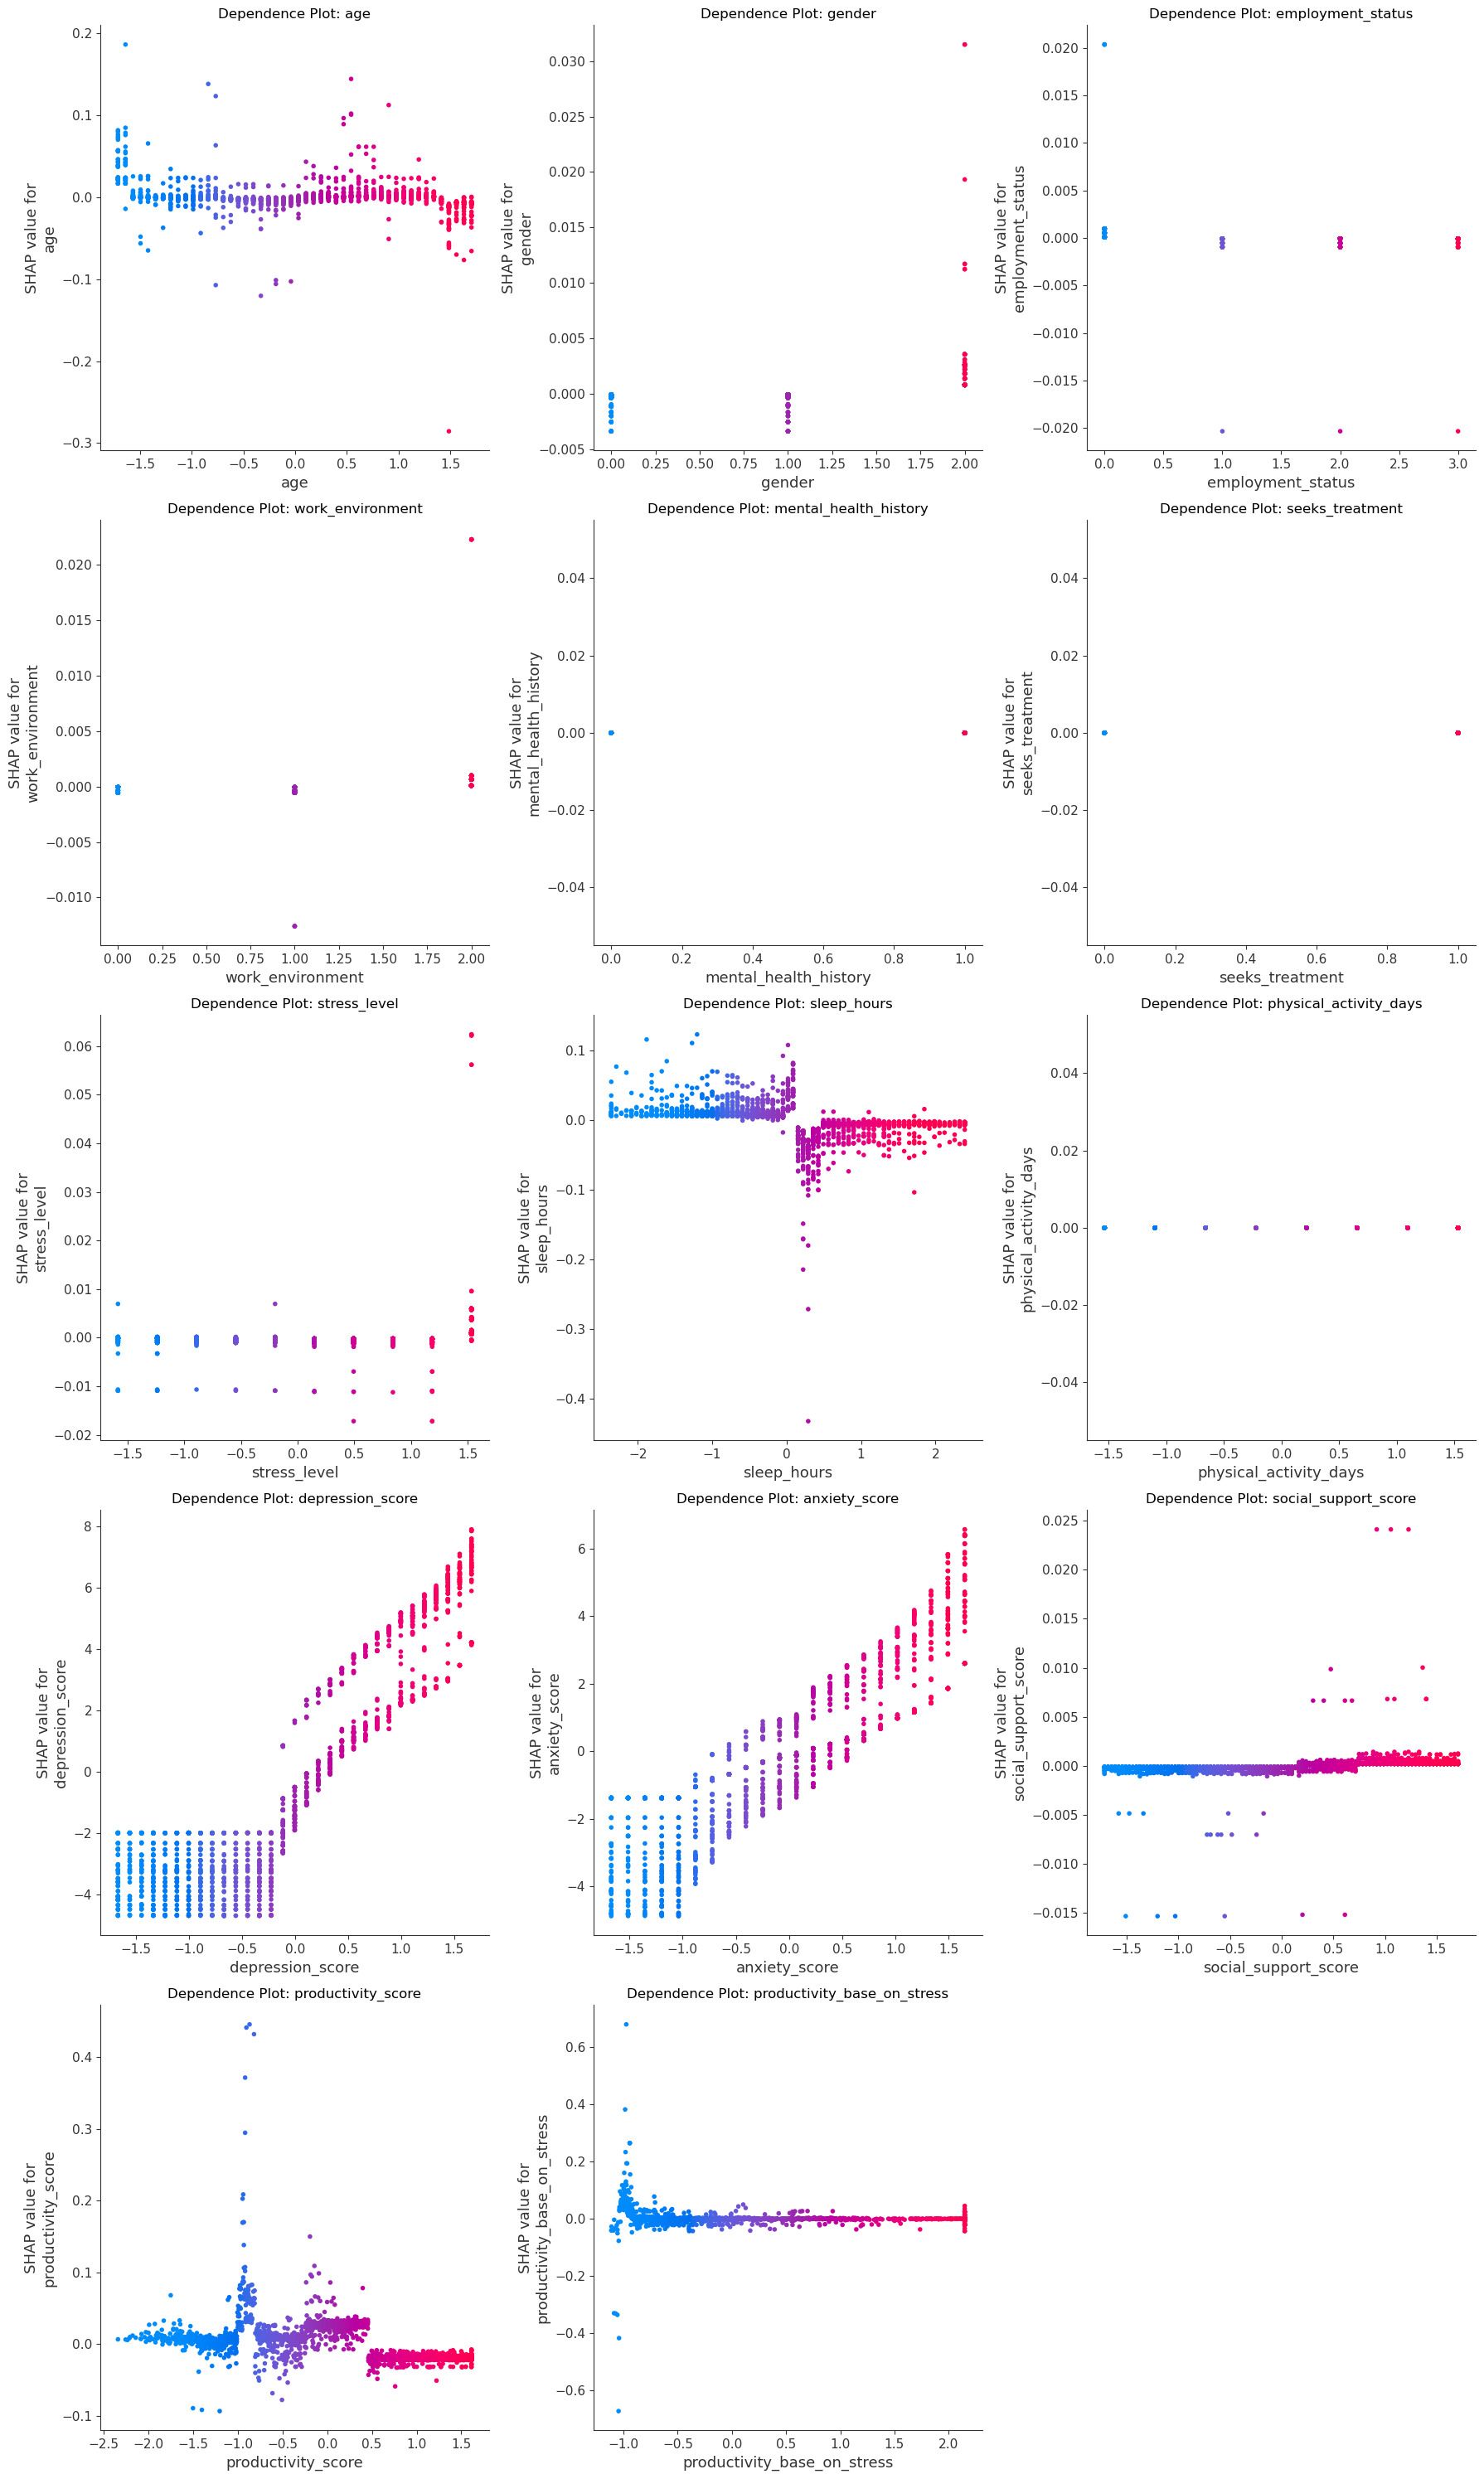

In [42]:
pipe.shap_dependence()

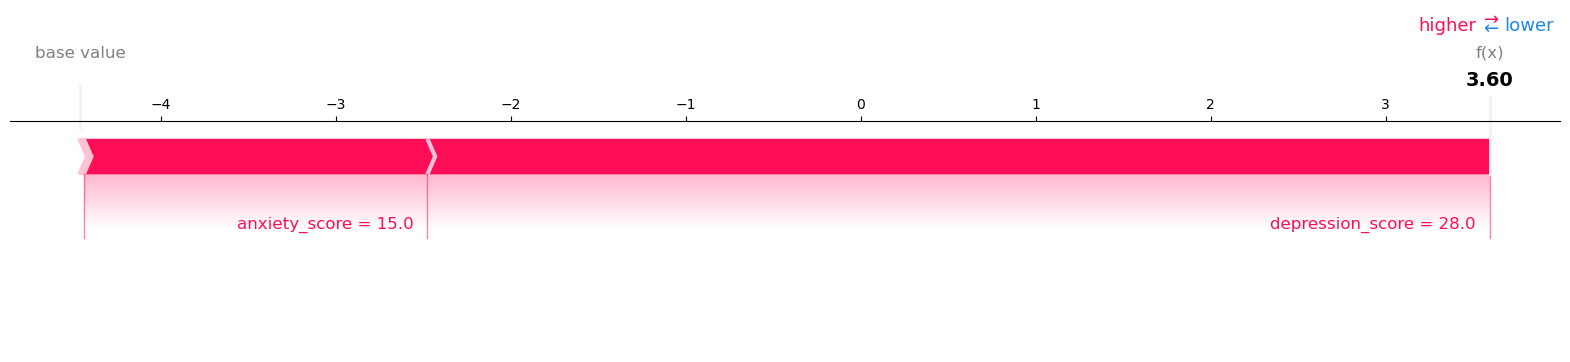

In [43]:
pipe.shap_force()

### **3.6.2. BEST MODEL VỚI GRID SEARCH**

In [44]:
# Tối ưu với grid
best_model = pipe.select_best_model(method="grid")

Mô hình tốt nhất: xgboost


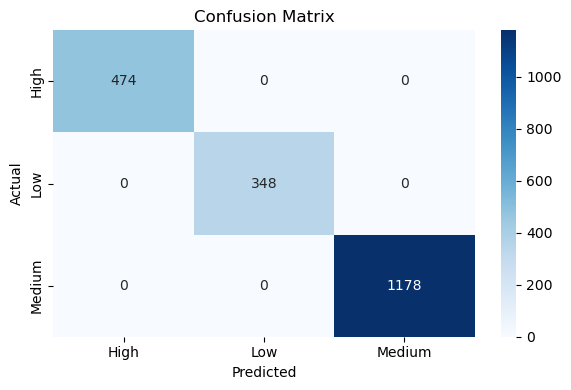

accuracy  precision  recall   f1  roc_auc_ovr
0       1.0        1.0     1.0  1.0          1.0

In [45]:
print("Mô hình tốt nhất:", best_model["best_model_name"])
pipe.evaluate(encoders=encoders)

In [46]:
print("Đánh giá cho tất cả các mô hình:")
best_model["all_metrics"]

Đánh giá cho tất cả các mô hình:


model_name  accuracy  precision    recall        f1  roc_auc_ovr
3      lightgbm    1.0000   1.000000  1.000000  1.000000     1.000000
2       xgboost    1.0000   1.000000  1.000000  1.000000     1.000000
0      logistic    0.9995   0.999298  0.999717  0.999507     0.999998
1  randomforest    0.9725   0.977250  0.962190  0.969377     0.998744

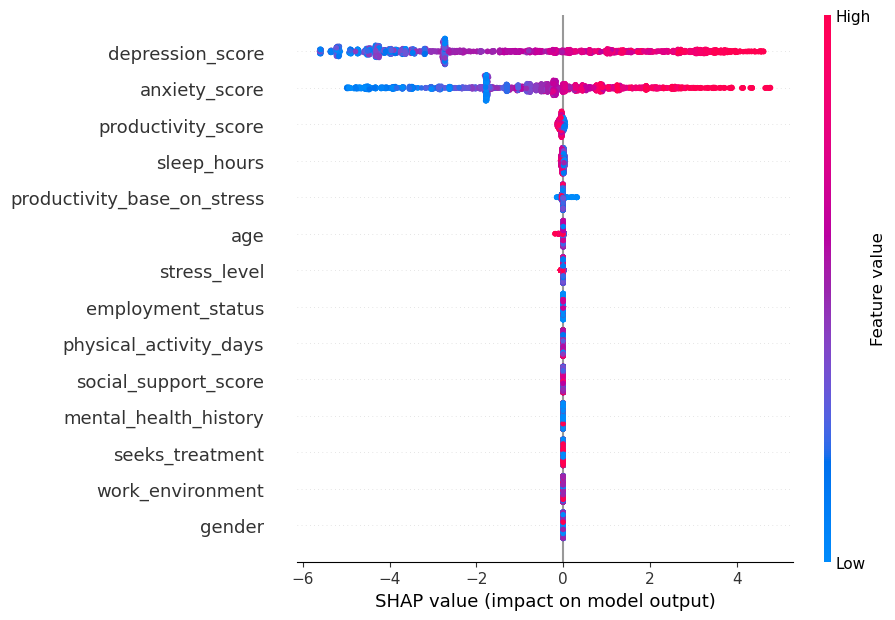

In [47]:
# Vẽ SHAP plot
pipe.shap_beeswarm()

In [48]:
pipe.shap_dependence()

In [49]:
pipe.shap_force()

In [50]:
# Lưu mô hình
pipe.save("Best_model_with_grid_search.pkl")

---
**Nhận xét:**
Khi chọn mô hình tốt nhất, kết quả trả về cho thấy các điểm hiệu suất giữa lightgbm và xgboost là như nhau nên ta sẽ chạy thử mô hình với lightgbm tối ưu tham số.

---

In [51]:
pipe.optimize_params(model_name="lightgbm", method="grid")

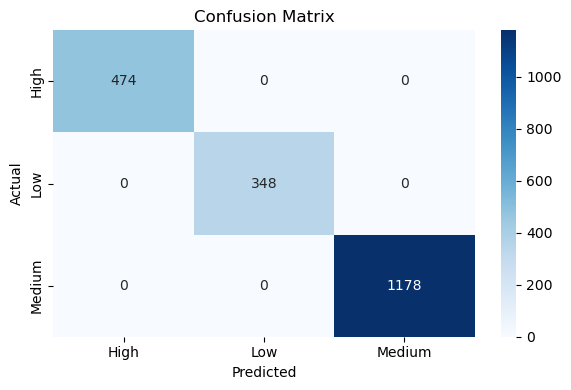

accuracy  precision  recall   f1  roc_auc_ovr
0       1.0        1.0     1.0  1.0          1.0

In [52]:
pipe.evaluate(encoders=encoders)

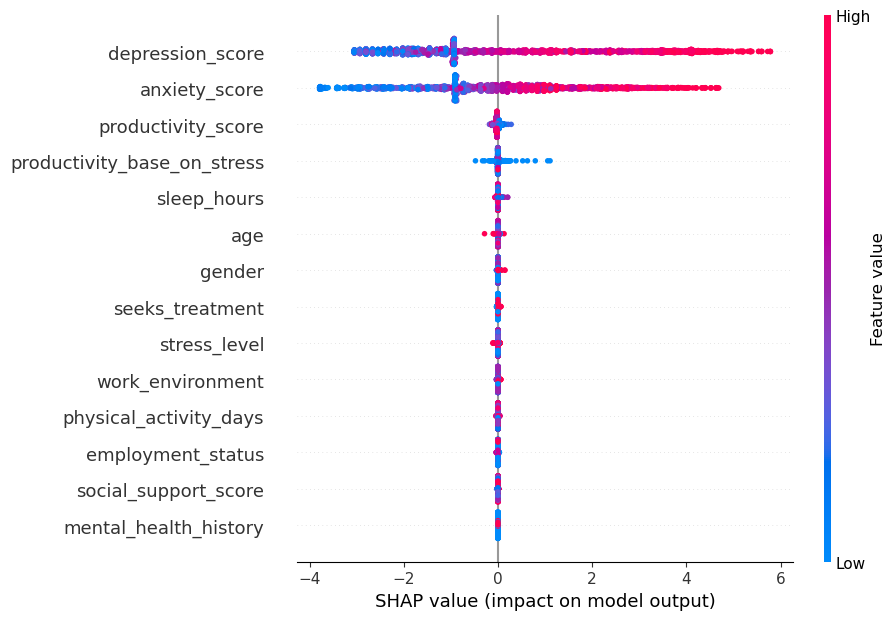

In [53]:
pipe.shap_beeswarm()

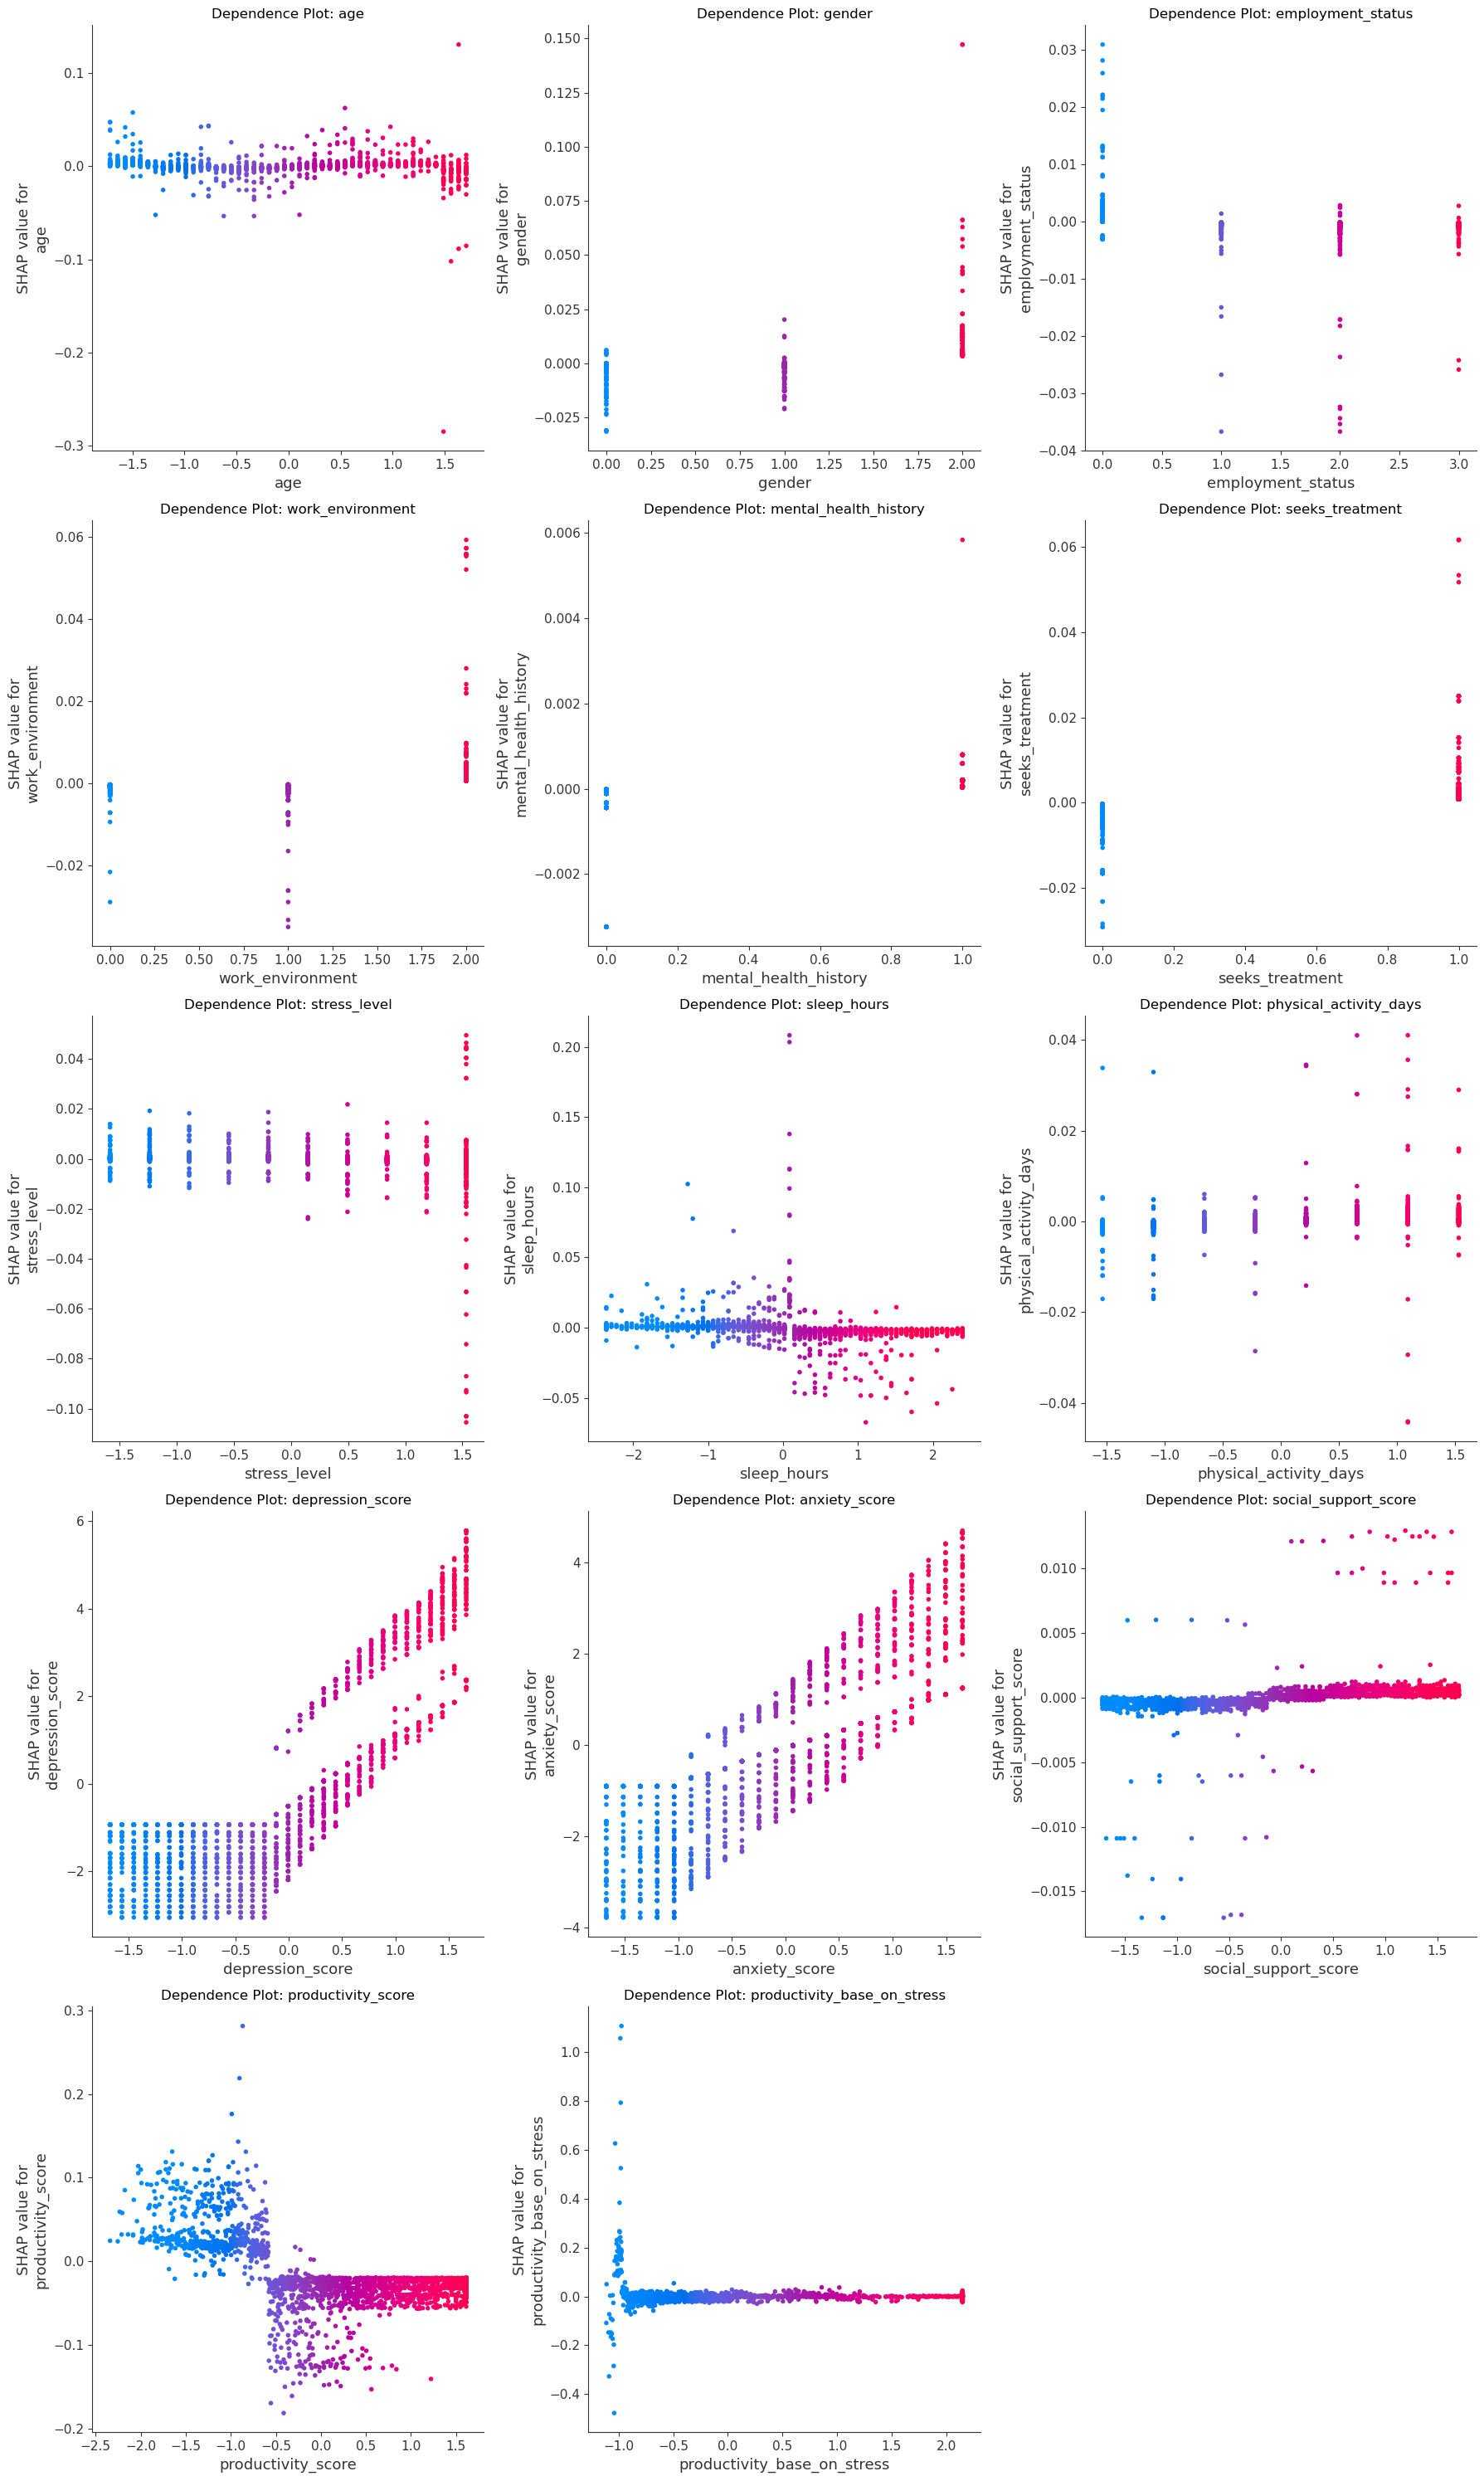

In [54]:
pipe.shap_dependence()

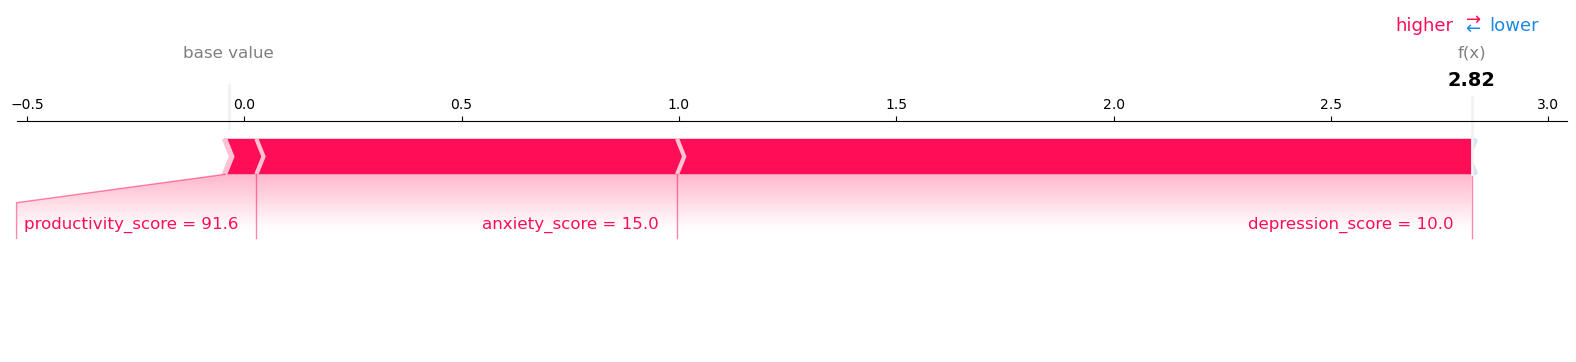

In [55]:
pipe.shap_force(sample_index=200)

### **3.6.3: LOAD MODEL**

In [58]:
pipe.load(input_path_str="Best_model_with_grid_search.pkl")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [59]:
pipe.load(input_path_str="Best_model_with_optuna.pkl")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8888030765280213, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.031239995578812668,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)